In [1]:
import sys 
sys.path.append('../scripts/')
from mcl import *
from scipy.stats import chi2  #追加

In [2]:
class KldMcl(Mcl): 
    def __init__(self, envmap, init_pose, max_num, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05, 
                widths = np.array([0.2, 0.2, math.pi/18]).T, epsilon=0.1, delta=0.01): #範囲、ステップ、サンプリングのパラメータを追加
        super().__init__(envmap, init_pose, 1, motion_noise_stds, distance_dev_rate, direction_dev)
        self.widths = widths                #パラメータ追加
        self.max_num = max_num
        self.epsilon = epsilon
        self.delta = delta
        self.binnum = 0         #描画用
        
    def motion_update(self, nu, omega, time): 
        ws = [e.weight for e in self.particles]    # 重みのリストを作る
        if sum(ws) < 1e-100: ws = [e + 1e-100 for e in ws]  #重みの和がゼロに丸め込まれるとサンプリングできなくなるので小さな数を足しておく
        
        new_particles = []
        bins = set()
        for i in range(self.max_num):
            p = random.choices(self.particles, weights=ws)  #1つだけ選ぶ
            moved_p = copy.deepcopy(p[0])
            moved_p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)  #移動
            bins.add(tuple(math.floor(e) for e in moved_p.pose/self.widths))        #ビンのインデックスをsetに登録（角度を正規化するとより良い）
            new_particles.append(moved_p)                                                                       #新しいパーティクルのリストに追加
            
            self.binnum = len(bins) if len(bins) > 1 else 2     #ビンの数が1の場合2にしないと次の行の計算ができない
            if  len(new_particles) > math.ceil(chi2.ppf(1.0 - self.delta, self.binnum-1)/(2*self.epsilon)):
                break
            
        self.particles = new_particles
        for i in range(len(self.particles)): #正規化
            self.particles[i].weight = 1.0/len(self.particles)
            
    def observation_update(self, observation): 
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
        self.set_ml() #リサンプリング前に実行
#        self.resampling() 

    def draw(self, ax, elems):  
        super().draw(ax, elems)
        elems.append(ax.text(-4, -4, "{}, {}".format(len(self.particles), self.binnum), fontsize=8))

In [3]:
class KldMclAgent(MclAgent): 
    def __init__(self, time_interval, nu, omega, particle_pose, envmap, max_particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}): #2行目にenvmapを追加
        super().__init__(time_interval, nu, omega, particle_pose, envmap, 1, motion_noise_stds)
        self.pf = KldMcl(envmap, particle_pose, max_particle_num, motion_noise_stds) #MclからKldMclにself.pfの中身を入れ替え

<IPython.core.display.Javascript object>


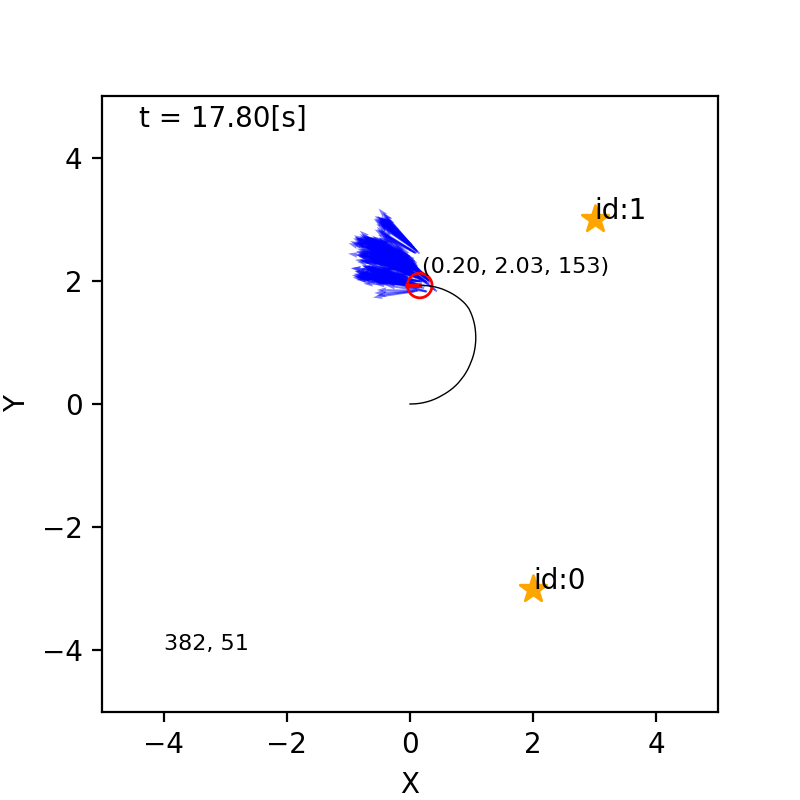

In [4]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ## 地図を生成して2つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ## ロボットを作る ##
    a = KldMclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m, max_particle_num=1000)
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()